<a href="https://colab.research.google.com/github/reedmarkham/meter-made/blob/main/meter_made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import itertools

from google.colab import drive
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import geopandas as gpd
import folium
import branca.colormap as cm
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=9551588aff332ed0e8b9cef02c78ee9ebc9d2ecb6e0369de03fb05c626753087
  Stored in directory: /root/.cache/pip/wheels/b9/c6/5a/829298789e94348b81af52ab42c19d49da007306bbcc983827
Successfully built pandarallel
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load the DC parking data previously downloaded to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/dc-parking-data'

Mounted at /content/drive
Accessible_Parking_Zones.geojson		    Parking_Zones.geojson
Address_Points.geojson				    Residential_and_Visitor_Parking_Zones.geojson
Parking_Blockface.geojson			    Roadway_Blockface.geojson
Parking_Violations_Issued_in_December_2024.geojson  Street_Right_Of_Way.geojson
Parking_Violations_Issued_in_June_2024.geojson	    Valet_Parking.geojson


# Check out the DC parking zones (street sweeping routes)

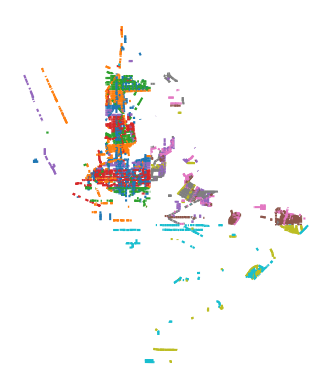

In [ ]:
zones = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Zones.geojson')
ax = zones[zones.PARKINGGROUP == 'Sweeping'].plot(column='ROUTEID')
ax.set_axis_off()

# Ingest addresses and routes

In [ ]:
addresses = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Address_Points.geojson')
a_cols = ['ADDRESS', 'ZIPCODE', 'BLOCKKEY', 'ROUTEID', 'LATITUDE', 'LONGITUDE']
addresses = addresses[a_cols]

# & (gdf.ROUTEID == '11072862')
routes = zones[(zones.PARKINGGROUP == 'Sweeping') & (zones.PARKINGDAYGROUP == 'Monday') & (zones.PARKINGHOURGROUP == 'AM')].set_crs('EPSG:4326')
routes = routes.sort_values(by='MEAS_FROM')
r_cols = ['ROUTEID', 'ZONEID', 'SIGNS', 'SIGNTEXT', 'SIGNCODE', 'MEAS_FROM', 'MEAS_TO', 'STARTTIME', 'ENDTIME', 'BLOCKFACEKEY', 'geometry']
routes = routes[r_cols]

routes_df = routes.merge(addresses, on='ROUTEID', how='inner')
routes_gdf = gpd.GeoDataFrame(
    routes_df,
    geometry=gpd.points_from_xy(routes_df.LONGITUDE, routes_df.LATITUDE),
    crs='EPSG:4326'
)

display(routes_gdf.sort_values(by='ADDRESS'))

,ROUTEID,ZONEID,SIGNS,SIGNTEXT,SIGNCODE,MEAS_FROM,MEAS_TO,STARTTIME,ENDTIME,BLOCKFACEKEY,geometry,ADDRESS,ZIPCODE,BLOCKKEY,LATITUDE,LONGITUDE
162405,11068382,b17df5ba43d9090d7fb1c6888ad5710c-left-1,"69707B76,9406DFDD",,R-NS-022,2436.798096,2517.250244,23.0,31.0,b17df5ba43d9090d7fb1c6888ad5710c,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
174799,11068382,5a1ef58455d9e8f59882cd6be3db8cec-left-0,"6C18511A,B49A4FF8,06C552E7,D85114EC",None,R-NS-022,2589.184814,2700.219482,23.0,31.0,5a1ef58455d9e8f59882cd6be3db8cec,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
223608,11068382,b29d88b46d5cd801e5007dc09163857f-right-2,"C4A733FA,E70DB290,2A48C50B,1FB37F0B,430D2FE0",,R-NS-022,3543.365479,3701.366455,23.0,31.0,b29d88b46d5cd801e5007dc09163857f,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
157253,11068382,84cf5ad23b44a52bbab608c63339bc8e-left-1,"BDA72933,74D960FB",,R-NS-022,2336.048096,2425.520508,23.0,31.0,84cf5ad23b44a52bbab608c63339bc8e,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
171602,11068382,46a76de4c58cce77f347c18c4d4d3525-left-0,DB9F1379,,R-NS-022,2529.746826,2576.688232,23.0,31.0,46a76de4c58cce77f347c18c4d4d3525,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312150,11000902,0fbbc26c002e9b0bc4e6092049110bdb-left-1,"FB648B3A,D193CC03",,R-NS-022,7060.233398,7100.389648,23.0,31.0,0fbbc26c002e9b0bc4e6092049110bdb,POINT (-77.02397 38.88975),None,20004.0,ea6918a50e1295d78553a3d6f022e8b5,38.889749,-77.023974
312340,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234
312968,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02923 38.96446),None,20011.0,c2d1955d497def9cef4c8fdb1230459d,38.964463,-77.029228
313250,11001302,19988afe7a283be8f02099b1b4f7a904-right-1,"C21C8818,D35B104F",,R-NS-022,7170.645020,7207.974609,23.0,31.0,19988afe7a283be8f02099b1b4f7a904,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234


# Ingest tickets

In [ ]:
t = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_June_2024.geojson')

tickets = gpd.GeoDataFrame(
    t,
    geometry=gpd.points_from_xy(t.LONGITUDE, t.LATITUDE),
    crs="EPSG:4326"
)

# Fill NaN values in VIOLATION_PROC_DESC with an empty string before using .str.contains()
tickets['VIOLATION_PROC_DESC'] = tickets['VIOLATION_PROC_DESC'].fillna('')

display(tickets[tickets.VIOLATION_PROC_DESC.str.contains('EXPIRED METER')])

,OBJECTID,TICKET_NUMBER,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,LOCATION,PLATE_STATE,...,YCOORD,LATITUDE,LONGITUDE,MAR_ID,GIS_LAST_MOD_DTTM,VIOLATION_PROC_DESC,VEHICLE_TYPE,MULTI_OWNER_NUMBER,DISPOSITION_DESC,geometry
164,83177787,280259103,2024-06-11 04:00:00+00:00,1035,57,METRO POLICE,MTP,P039,1101 HOWARD RD SE,,...,132706.81,38.862,-76.995,294866.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.862)
177,83177800,280260573,2024-06-10 04:00:00+00:00,1052,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,950002387,DISM NOI SUBM LATE,POINT (-76.994 38.934)
178,83177801,280260584,2024-06-16 04:00:00+00:00,1059,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM MAKE MISMATCH,POINT (-76.994 38.934)
179,83177802,280260595,2024-06-10 04:00:00+00:00,1100,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.994 38.934)
180,83177803,280260606,2024-06-10 04:00:00+00:00,1102,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.994 38.934)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97289,83379818,280260304,2024-06-25 04:00:00+00:00,1059,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)
97290,83379819,280260326,2024-06-25 04:00:00+00:00,1101,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)
97291,83379820,280260330,2024-06-25 04:00:00+00:00,1103,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,REAR 850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)
97292,83379821,280260341,2024-06-25 04:00:00+00:00,1105,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,REAR 850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)


# Join street cleaning parking tickets with sweeping routes

In [ ]:
routes_gdf.geometry = routes_gdf.geometry.set_precision(grid_size=0.0001).force_2d()
cleaning_tix = tickets[tickets.VIOLATION_CODE == 'P173']
cleaning_tix.geometry = cleaning_tix.geometry.set_precision(grid_size=0.0001).force_2d()
tickets_and_routes = gpd.sjoin(routes_gdf, cleaning_tix, how='inner', predicate='intersects')
tickets_and_routes = tickets_and_routes[['TICKET_NUMBER', 'ROUTEID', 'ISSUE_DATE', 'ISSUE_TIME', 'geometry']]
tickets_and_routes = tickets_and_routes.sort_values(by='TICKET_NUMBER').drop_duplicates()
tickets_and_routes.geometry = tickets_and_routes.geometry.set_precision(grid_size=0.00001)
display(tickets_and_routes)

/usr/local/lib/python3.11/dist-packages/shapely/_geometry.py:814: RuntimeWarning: invalid value encountered in set_precision
  return lib.set_precision(geometry, grid_size, np.intc(mode), **kwargs)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,TICKET_NUMBER,ROUTEID,ISSUE_DATE,ISSUE_TIME,geometry
56235,8262204646,11064872,2024-06-03 04:00:00+00:00,1029,POINT (-77.021 38.96)
255286,8262205070,11001302,2024-06-04 04:00:00+00:00,1047,POINT (-77.03 38.937)
202608,8262205081,11001302,2024-06-04 04:00:00+00:00,1048,POINT (-77.03 38.937)
269330,8262205092,11001302,2024-06-04 04:00:00+00:00,1050,POINT (-77.03 38.937)
303474,8262205103,11001302,2024-06-04 04:00:00+00:00,1054,POINT (-77.03 38.936)
...,...,...,...,...,...
15817,8268474583,11025932,2024-06-26 04:00:00+00:00,1014,POINT (-77.031 38.912)
15749,8268519545,11025932,2024-06-26 04:00:00+00:00,1122,POINT (-77.031 38.912)
15817,8268519556,11025932,2024-06-26 04:00:00+00:00,1124,POINT (-77.031 38.912)
15817,8268519560,11025932,2024-06-26 04:00:00+00:00,1125,POINT (-77.031 38.912)


In [ ]:
tickets_and_routes['timestamp'] = tickets_and_routes.apply(
    lambda row: str(row['ISSUE_DATE'].date()) + ' ' + row['ISSUE_TIME'],
    axis=1
    )

tickets_and_routes['timestamp'] = pd.to_datetime(
    tickets_and_routes['timestamp'],
    format='%Y-%m-%d %H%M',
    errors='coerce'
    )

tickets_and_routes = tickets_and_routes[['geometry', 'ROUTEID', 'timestamp']]

display(tickets_and_routes)

,geometry,ROUTEID,timestamp
56235,POINT (-77.021 38.96),11064872,2024-06-03 10:29:00
255286,POINT (-77.03 38.937),11001302,2024-06-04 10:47:00
202608,POINT (-77.03 38.937),11001302,2024-06-04 10:48:00
269330,POINT (-77.03 38.937),11001302,2024-06-04 10:50:00
303474,POINT (-77.03 38.936),11001302,2024-06-04 10:54:00
...,...,...,...
15817,POINT (-77.031 38.912),11025932,2024-06-26 10:14:00
15749,POINT (-77.031 38.912),11025932,2024-06-26 11:22:00
15817,POINT (-77.031 38.912),11025932,2024-06-26 11:24:00
15817,POINT (-77.031 38.912),11025932,2024-06-26 11:25:00


# Visualize frequency and order (by ticket timestamp) of parking tickets along routes

In [ ]:
DC_COORDS = [38.90720, -77.03690]

map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

#TO-DO: compute elapsed_minutes within ROUTEID as well as colormap but then plot for each ROUTEID layer the respective colormap and elapsed_minutes in popup ("since street cleaning route started")

tickets_and_routes['elapsed_minutes'] = (tickets_and_routes['timestamp'] - tickets_and_routes['timestamp'].min()).dt.total_seconds() / 60

colormap = cm.linear.Blues_03.scale(
    tickets_and_routes.elapsed_minutes.min(),
    tickets_and_routes.elapsed_minutes.max()
    )

geometry_counts = tickets_and_routes.groupby(['geometry', 'ROUTEID'])['timestamp'].count().reset_index()
earliest_timestamps = tickets_and_routes.groupby(['geometry', 'ROUTEID'])['timestamp'].min().rename('earliest_timestamp').reset_index()

route_layers = {}
for route_id in tickets_and_routes['ROUTEID'].unique():
  route_data = tickets_and_routes[tickets_and_routes['ROUTEID'] == route_id]
  route_fg = folium.FeatureGroup(name=f"Route {route_id}")

  for idx, row in route_data.sort_values(by='elapsed_minutes').iterrows():
      lon = row.geometry.x
      lat = row.geometry.y
      count_for_geometry = int(geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].iloc[0] if geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].size > 0 else 0)
      earliest_timestamp = earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].iloc[0]

      popup_html = f"""
      <h1> Street sweeping summary:</h1>
      <p># of tickets: {count_for_geometry}</p>
      <p>Started at: {earliest_timestamp}</p>
      """

      folium.CircleMarker(
          location=[lat, lon],
          radius=count_for_geometry,
          color='none',
          fill=True,
          fill_color=colormap(row.elapsed_minutes),
          fill_opacity=0.7,
          popup=popup_html
      ).add_to(route_fg)

  route_layers[route_id] = route_fg
  route_fg.add_to(map)


colormap.add_to(map)
folium.LayerControl().add_to(map)

map

# Compute clusters of expired parking meter ticket locations (x, y coords)

In [ ]:
tix = tickets[tickets.VIOLATION_CODE == 'P039']

array_data = []
for index, row in tix.iterrows():
  if row.geometry and row.geometry.is_valid and not row.geometry.is_empty:
    x_coord = row.geometry.x
    y_coord = row.geometry.y
    date = row['ISSUE_DATE'].date()

    try:
        time_of_day = datetime.time(int(row['ISSUE_TIME'].zfill(4)[:2]), int(row['ISSUE_TIME'].zfill(4)[2:]))
    except (ValueError, TypeError):
        print(f"Invalid time format: {row['ISSUE_TIME']}, skipping row")
        continue

    #day_of_week =  row['ISSUE_DATE'].date().isoweekday()
    array_data.append([x_coord, y_coord, date, time_of_day])

X_full = np.array(array_data)
X_full_df = pd.DataFrame(X_full, columns=['x', 'y', 'd', 't'])
X_full_df['h'] = X_full_df['t'].apply(lambda t: (t.hour + (t.minute + 30) // 60) % 24)
X_full = X_full_df.values
display(pd.DataFrame(X_full, columns=['x', 'y', 'd', 't', 'h']))

,x,y,d,t,h
0,-76.995,38.862,2024-06-11,10:35:00,11
1,-76.994,38.934,2024-06-10,10:52:00,11
2,-76.994,38.934,2024-06-16,10:59:00,11
3,-76.994,38.934,2024-06-10,11:00:00,11
4,-76.994,38.934,2024-06-10,11:02:00,11
...,...,...,...,...,...
3118,-76.995,38.865,2024-06-25,10:59:00,11
3119,-76.995,38.865,2024-06-25,11:01:00,11
3120,-76.995,38.865,2024-06-25,11:03:00,11
3121,-76.995,38.865,2024-06-25,11:05:00,11


In [ ]:
# prompt: Write a function that filters X_full_df for values of d and h. Then compute k-means clusters centroids within the filtered data. Print the results in an example function call

def compute_kmeans_cluster_centers(X_full, d, h):
  """
  Filters X_full by d and h, and then computes centers of k-mean clusters (k=8) in the result dataset.

  Args:
    X_full: A NumPy array with columns [x, y, d, t, h].
    d: The date to filter by.
    h: The hour to filter by.

  Returns:
    A list of cluster center coordinates for the filtered data.
  """
  X_filtered = X_full[(X_full[:, 2] == d) & (X_full[:, 4] == h)]
  if len(X_filtered) > 0:
    kmeans = KMeans(n_clusters=8, random_state=0)
    kmeans.fit(X_filtered[:, :2])  # Fit on x, y coordinates
    return kmeans.cluster_centers_
  else:
    return []


# Example function call
example_date = datetime.date(2024, 6, 25)
example_hour = 11
cluster_centers = compute_kmeans_cluster_centers(X_full, example_date, example_hour)

if len(cluster_centers) > 0:
  print(f"Cluster centers for date {example_date} and hour {example_hour}:")
  for center in cluster_centers:
    print(center)
else:
  print(f"No data found for date {example_date} and hour {example_hour}.")


Cluster centers for date 2024-06-25 and hour 11:
[-77.008  38.899]
[-76.995  38.865]
[-77.037  38.907]
[-77.042  38.898]
[-77.02   38.887]
[-77.05   38.903]
[-77.04   38.897]
[-77.038  38.907]


In [ ]:
# prompt: Write a function that filters X_full_df for values of d and h. Then compute k-means clusters centroids within the filtered data. Print the results in an example function call

def compute_kmeans_cluster_centers(X_full, d, h):
  """
  Filters X_full by d and h, and then computes centers of k-mean clusters (k=8) in the result dataset.

  Args:
    X_full: A NumPy array with columns [x, y, d, t, h].
    d: The date to filter by.
    h: The hour to filter by.

  Returns:
    A list of cluster center coordinates for the filtered data.
  """
  X_filtered = X_full[(X_full[:, 2] == d) & (X_full[:, 4] == h)]
  if len(X_filtered) > 0:
    n_clusters = min(len(X_filtered), 8)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_filtered[:, :2])  # Fit on x, y coordinates
    return kmeans.cluster_centers_
  else:
    return []


# Example function call
example_date = datetime.date(2024, 6, 25)
example_hour = 11
cluster_centers = compute_kmeans_cluster_centers(X_full, example_date, example_hour)

# Check if cluster_centers is not empty instead of directly evaluating its truthiness
if len(cluster_centers) > 0: # Changed this line to check if the cluster_centers array is not empty using len()
  print(f"Cluster centers for date {example_date} and hour {example_hour}:")
  for center in cluster_centers:
    print(center)
else:
  print(f"No data found for date {example_date} and hour {example_hour}.")

Cluster centers for date 2024-06-25 and hour 11:
[-77.008  38.899]
[-76.995  38.865]
[-77.037  38.907]
[-77.042  38.898]
[-77.02   38.887]
[-77.05   38.903]
[-77.04   38.897]
[-77.038  38.907]


In [ ]:
# Generate all possible (d, h) combinations
combinations = list(itertools.product(X_full_df['d'].unique(), X_full_df['h'].unique()))

# Initialize an empty list to store cluster centers for each (d, h)
cluster_centers_list = []

# Loop through each (d, h) combination
for d, h in combinations:
  # Compute cluster centers for the current (d, h)
  cluster_centers = compute_kmeans_cluster_centers(X_full, d, h)

  # Append the cluster centers and (d, h) to the list
  if len(cluster_centers) > 0:
    for center in cluster_centers:
      cluster_centers_list.append([d, h, *center])

# Create a DataFrame from the list of cluster centers
cluster_centers_df = pd.DataFrame(cluster_centers_list, columns=['d', 'h', 'cluster_x', 'cluster_y'])

# Display the DataFrame
display(cluster_centers_df.sort_values(by=['d','h']))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:

,d,h,cluster_x,cluster_y
187,2024-06-01,7,-77.002,38.887
176,2024-06-01,9,-77.005,38.884
150,2024-06-01,10,-77.012,38.897
144,2024-06-01,11,-77.033,38.947
145,2024-06-01,11,-76.984,38.915
...,...,...,...,...
632,2024-06-29,22,-77.050,38.900
633,2024-06-29,22,-77.050,38.897
634,2024-06-29,22,-77.050,38.897
635,2024-06-29,22,-77.050,38.897


In [ ]:
test_cluster_centers = cluster_centers_df[(cluster_centers_df.d == datetime.date(2024, 6, 25)) & (cluster_centers_df.h == 11)]
test_clusters_gdf = gpd.GeoDataFrame(
    test_cluster_centers,
    geometry=gpd.points_from_xy(test_cluster_centers.cluster_x, test_cluster_centers.cluster_y),
    crs='EPSG:4326'
)
test_clusters_gdf = test_clusters_gdf.to_crs('EPSG:32618')
display(test_clusters_gdf.geometry)

,geometry
1113,POINT (325869.216 4307485.109)
1114,POINT (326914.146 4303686.937)
1115,POINT (323373.987 4308428.755)
1116,POINT (322918.038 4307439.594)
1117,POINT (324799.009 4306176.285)
1118,POINT (322236.689 4308010.08)
1119,POINT (323089.011 4307324.729)
1120,POINT (323287.27 4308430.693)


In [ ]:
addresses_gdf = gpd.GeoDataFrame(
    addresses,
    geometry=gpd.points_from_xy(addresses.LONGITUDE, addresses.LATITUDE),
    crs='EPSG:4326'
)

print(addresses_gdf.estimate_utm_crs())

addresses_gdf = addresses_gdf.to_crs('EPSG:32618')
display(addresses_gdf)

EPSG:32618


,ADDRESS,ZIPCODE,BLOCKKEY,ROUTEID,LATITUDE,LONGITUDE,geometry
0,2007 TRENTON PLACE SE,20020.0,fcc2902237670f79fd0c30c4961fe21a,13086512,38.845132,-76.974967,POINT (328604.633 4301444.102)
1,1302 TRINIDAD AVENUE NE,20002.0,5cd350f7c73565a6f74f5eb14e25db45,12086642,38.903633,-76.986230,POINT (327768.448 4307957.986)
2,1327 UNDERWOOD STREET NW,20012.0,c58ece6c0a1197f3d49c7d4a6bf58224,11087422,38.969201,-77.030962,POINT (324051.426 4315320.451)
3,511 BRUMMEL COURT NW,20012.0,a5f5ff0dda8bb1bfba7cc2769e60f98f,11018622,38.980000,-77.021572,POINT (324891.614 4316500.848)
4,4712 ALTON PLACE NW,20016.0,a993c626df78a7581d377b3d6e91033b,11010072,38.946903,-77.093389,POINT (318585.791 4312968.166)
...,...,...,...,...,...,...,...
144396,430 INGRAHAM STREET NE,20011.0,8f1ad7cd182f8a5a3aaafda96c6c000d,12048422,38.953901,-76.999537,POINT (326736.838 4313562.064)
144397,1228 WYNTON PLACE NE,20017.0,0a82058ea21ade94e4a574544a440eed,12094782,38.944385,-76.988813,POINT (327643.107 4312485.607)
144398,1235 WYNTON PLACE NE,20017.0,0a82058ea21ade94e4a574544a440eed,12094782,38.944110,-76.988641,POINT (327657.373 4312454.756)
144399,1211 ALLISON STREET NE,20017.0,ee9cc522e3905837df9afd77f68532c4,12009882,38.945089,-76.989226,POINT (327608.99 4312564.516)


In [ ]:
a_gdf = addresses_gdf[['ADDRESS', 'geometry']]
a_gdf['min_dist'] = a_gdf.parallel_apply(lambda row: row.geometry.distance(test_clusters_gdf.geometry).min()/1609.34, axis=1)
display(a_gdf)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ADDRESS,geometry,min_dist
0,2007 TRENTON PLACE SE,POINT (328604.633 4301444.102),1.745168
1,1302 TRINIDAD AVENUE NE,POINT (327768.448 4307957.986),1.216160
2,1327 UNDERWOOD STREET NW,POINT (324051.426 4315320.451),4.302951
3,511 BRUMMEL COURT NW,POINT (324891.614 4316500.848),5.103656
4,4712 ALTON PLACE NW,POINT (318585.791 4312968.166),3.825945
...,...,...,...
144396,430 INGRAHAM STREET NE,POINT (326736.838 4313562.064),3.813206
144397,1228 WYNTON PLACE NE,POINT (327643.107 4312485.607),3.296889
144398,1235 WYNTON PLACE NE,POINT (327657.373 4312454.756),3.281819
144399,1211 ALLISON STREET NE,POINT (327608.99 4312564.516),3.336210


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

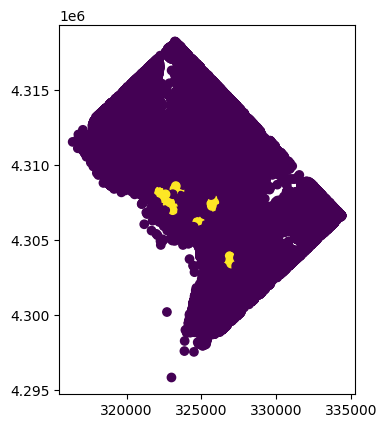

In [ ]:
def estimate_ticket(dist):
  return 1 if dist < 0.25 else 0

a_gdf['ticketed'] = a_gdf['min_dist'].apply(estimate_ticket)
a_gdf.plot(column='ticketed')